基本的思路就是只用bar和piece的scale信息反推被截断的长度（尽管大多数情况都没截断），然后反推出小块的位置占还原的bar的比例。

不用tank是因为结果不太稳健，有时根本检测不到，有时误差也比较大。

In [1]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image


In [2]:
import cv2 as cv
import os
import numpy as np


In [41]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

%matplotlib inline

def rectangle(xy, width, height, edgecolor='r', linewidth=1, facecolor='none'):
    rect = patches.Rectangle(xy, width, height, linewidth=linewidth, 
                             edgecolor=edgecolor, facecolor=facecolor)
    plt.gca().add_patch(rect)

def show_detection(img, boxes, show=True, text_list = None,
                   fontsize = 12):
    plt.imshow(img)
    for i,box in enumerate(boxes):
        xmin,ymin,xmax,ymax = box
        #print((xmin,ymin), xmax-xmin, ymax-ymin)
        rectangle((xmin,ymin), xmax-xmin, ymax-ymin)
        if text_list is not None:
            plt.text(xmin, ymin-30, text_list[i], fontsize=fontsize, bbox=dict(facecolor='purple', alpha=0.1))
    if show:
        plt.show()
        
def show_detection2(img, boxes_ltwh, **kwargs):
    boxes_ltrb = []
    for left,top,width,height in boxes_ltwh:
        boxes_ltrb.append([ left, top, left + width, top + height])
    show_detection(img, boxes_ltrb, **kwargs)

In [3]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [4]:
# Load names of classes
classesFile = "voc.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
#modelConfiguration = os.path.abspath("yolov3-tiny-tank.cfg")
#modelWeights = os.path.abspath("backup_YOLO/yolov3-tiny-tank_19000.weights")
modelConfiguration = "yolov3-tiny-tank.cfg"
modelWeights = "backup_YOLO/yolov3-tiny-tank_19000.weights"

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)


In [5]:
def detect(frame):
    
    # Create a 4D blob from a frame.
    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))
    
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])
                
    return classIds,confidences,boxes

In [81]:
def preprocess(name):
    #name = '20180421153245.jpg' # multiple box
    img_path = os.path.join('data', name)
    frame_bgr = cv.imread(img_path)
    frame = cv.cvtColor(frame_bgr, cv.COLOR_BGR2RGB)

    classIds,confidences,boxes = detect(frame)
    return frame,classIds,confidences,boxes

In [45]:
'''
check_list = ['20180421153245_12_21.jpg', # small object
             '20180421153245.jpg', # multiple box
             ] 
for name in check_list:
'''
frame,classIds,confidences,boxes = preprocess('20180421153245.jpg') # multiple box

In [46]:
classIds,confidences,boxes

([2, 1, 0, 2],
 [0.7966243028640747,
  0.9998607635498047,
  0.9993453025817871,
  0.9997938275337219],
 [[844, 333, 213, 222],
  [838, 52, 223, 842],
  [420, 14, 1075, 1073],
  [861, 353, 191, 182]])

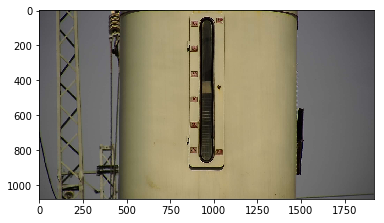

In [47]:
plt.imshow(frame)

In [48]:
max_bar_idx = None # 还是学C++的写法吧。。反正等下还要翻译成C++，这个写法本身的numpy写法也不算直观
max_piece_idx = None
max_bar_conf = 0
max_piece_conf = 0
for i in range(len(classIds)):
    if classIds[i] == 1:
        if confidences[i] > max_bar_conf:
            max_bar_conf = confidences[i]
            max_bar_idx = i
    elif classIds[i] == 2:
        if confidences[i] > max_piece_conf:
            max_piece_conf = confidences[i]
            max_piece_idx = i

max_bar_idx,max_bar_conf,max_bar_conf,max_piece_idx

(1, 0.9998607635498047, 0.9998607635498047, 3)

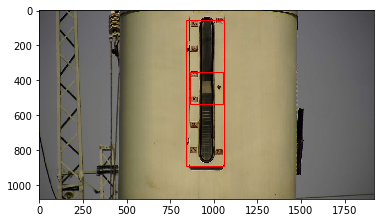

In [50]:
show_detection2(frame, [boxes[max_bar_idx], boxes[max_piece_idx]])

In [66]:
bar_left,bar_top,bar_width,bar_height = boxes[max_bar_idx]
piece_left,piece_top,piece_width,piece_height = boxes[max_piece_idx]
bar_right = bar_left+bar_width
bar_bottom = bar_top + bar_height
piece_right = piece_left + piece_width
piece_bottom = piece_top + piece_height

In [67]:
bar_left,bar_top,bar_right,bar_bottom,bar_width,bar_height

(838, 52, 1061, 894, 223, 842)

In [68]:
piece_left,piece_top,piece_right,piece_bottom,piece_width,piece_height

(861, 353, 1052, 535, 191, 182)

In [69]:
((piece_top - bar_top) + (piece_bottom - bar_top))/2 / bar_height

0.4655581947743468

In [70]:
bar_height / bar_width

3.7757847533632285

可能是因为数据标注的原因，基本所有框上面都会缺一部分，所以我们需要把它补回来。或者由于没有对齐0轴，100轴等，我们可以
先验地截取一部分不同比例从上下两部分。

In [62]:
def adjust(box):
    left,top,width,height = box
    top_p = top + width *0.05
    height_p = height - width * 0.45
    return left,top_p,width,height_p

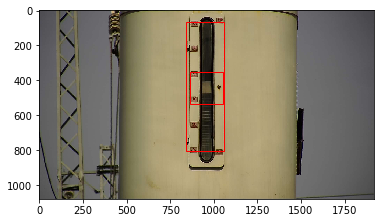

In [63]:
show_detection2(frame, [adjust(boxes[max_bar_idx]), boxes[max_piece_idx]])

In [64]:
bar_left,bar_top,bar_width,bar_height = adjust(boxes[max_bar_idx])
piece_left,piece_top,piece_width,piece_height = boxes[max_piece_idx]
bar_right = bar_left+bar_width
bar_bottom = bar_top + bar_height
piece_right = piece_left + piece_width
piece_bottom = piece_top + piece_height

In [65]:
((piece_top - bar_top) + (piece_bottom - bar_top))/2 / bar_height

0.5135171576889369

In [72]:
def extract_max(classIds, confidences):
    max_bar_idx = None # 还是学C++的写法吧。。反正等下还要翻译成C++，这个写法本身的numpy写法也不算直观
    max_piece_idx = None
    max_bar_conf = 0
    max_piece_conf = 0
    for i in range(len(classIds)):
        if classIds[i] == 1:
            if confidences[i] > max_bar_conf:
                max_bar_conf = confidences[i]
                max_bar_idx = i
        elif classIds[i] == 2:
            if confidences[i] > max_piece_conf:
                max_piece_conf = confidences[i]
                max_piece_idx = i
    return max_bar_idx, max_piece_idx


In [88]:
frame,classIds,confidences,boxes = preprocess('20180421153245_12_21.jpg') # multiple box

In [89]:
max_bar_idx, max_piece_idx = extract_max(classIds, confidences)

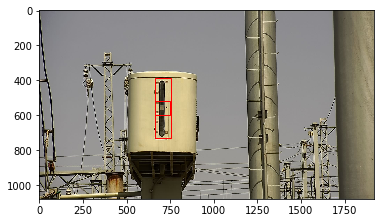

In [90]:
show_detection2(frame, [boxes[max_bar_idx], boxes[max_piece_idx]])

In [91]:
bar_left,bar_top,bar_width,bar_height = adjust(boxes[max_bar_idx])
piece_left,piece_top,piece_width,piece_height = boxes[max_piece_idx]
bar_right = bar_left+bar_width
bar_bottom = bar_top + bar_height
piece_right = piece_left + piece_width
piece_bottom = piece_top + piece_height

In [92]:
bar_height / bar_width

3.3192307692307694

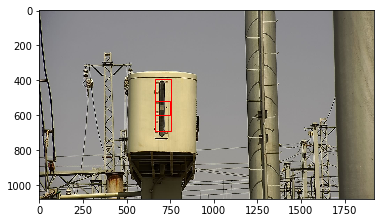

In [87]:
show_detection2(frame, [adjust(boxes[max_bar_idx]), boxes[max_piece_idx]])

In [93]:
((piece_top - bar_top) + (piece_bottom - bar_top))/2 / bar_height

0.5543784141698394

In [94]:
name = '20180629164558.jpg' # extrema value
frame,classIds,confidences,boxes = preprocess(name) # multiple box

In [95]:
max_bar_idx, max_piece_idx = extract_max(classIds, confidences)

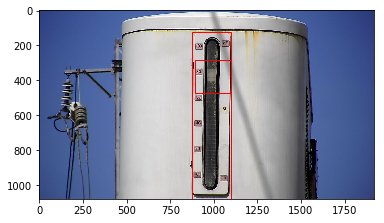

In [96]:
show_detection2(frame, [boxes[max_bar_idx], boxes[max_piece_idx]])

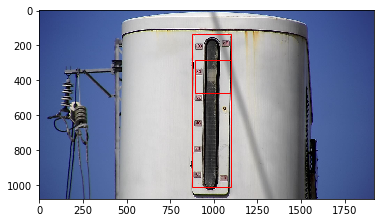

In [97]:
show_detection2(frame, [adjust(boxes[max_bar_idx]), boxes[max_piece_idx]])

In [98]:
bar_left,bar_top,bar_width,bar_height = boxes[max_bar_idx]
piece_left,piece_top,piece_width,piece_height = boxes[max_piece_idx]
bar_right = bar_left+bar_width
bar_bottom = bar_top + bar_height
piece_right = piece_left + piece_width
piece_bottom = piece_top + piece_height

In [99]:
((piece_top - bar_top) + (piece_bottom - bar_top))/2 / bar_height

0.2599591419816139

In [103]:
-((piece_top + piece_bottom)/2 - bar_bottom) / bar_height

0.7400408580183861

这样调来调去虽然可解释性比较强，但也称不上多合理，不如让网络按上面公式输出一个值，我再标注几个应有的值。然后回归一下。
出来的散点图也可以用来诊断一下。